# Deep Learning

## HW4- Problem 2 - Image captioning


1.   Full Name: Mohammad Kalbasi
2.   Student Number: 401211028

references:

https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

https://www.kaggle.com/code/visheshvats/image-caption-generation-on-coco-dataset-ipynb



https://medium.com/analytics-vidhya/cnn-lstm-architecture-and-image-captioning-2351fc18e8d7


In [1]:
!pip install pycocotools

from pycocotools.coco import COCO # COCO python library
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

import random
import string

import pickle 


import cv2
import os
from pickle import dump, load
import json

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

import tensorflow.keras.layers

from tensorflow.keras.models import Model, load_model

from tqdm.notebook import tqdm
from itertools import chain


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive') # we use google drive to load files and save models there! so change path files based on your own data and run the code!

Mounted at /content/gdrive


In [3]:
# first we have to load data images
instanceFile = "/content/gdrive/MyDrive/deep_learning/HW04/instances_train2017.json"
coco_annotation = COCO(instanceFile)

loading annotations into memory...
Done (t=23.79s)
creating index...
index created!


run this part to load all images, but it takes around 13 hours and crashes colab memory, so its better to just skip next part!

In [ ]:
imgIdss = coco_annotation.getImgIds()
img = coco_annotation.loadImgs(imgIdss[0])[0]
X = []
for id in tqdm(imgIdss):
  img = coco_annotation.loadImgs(id)[0]
  I = io.imread(img['coco_url'])
  X.append(I)



we have to define what categories we want for training network(because as we showed before, it's impossible to load all images), lets first see all categories and test different thing is COCO library

In [4]:
cat_ids = coco_annotation.getCatIds()
print(f"Number of Unique Categories: {len(cat_ids)}")
print("Category IDs:")
print(cat_ids)
cats = coco_annotation.loadCats(cat_ids)
cat_names = [cat["name"] for cat in cats]
print("Categories Names:")
print(cat_names)

# Category ID -> Category Name.
query_id = cat_ids[0]
query_annotation = coco_annotation.loadCats([query_id])[0]
query_name = query_annotation["name"]
query_supercategory = query_annotation["supercategory"]
print(f"Category ID: {query_id}, Category Name: {query_name}, Supercategory: {query_supercategory}")
query_name = cat_names[0]
query_id = coco_annotation.getCatIds(catNms=[query_name])[0]
print("Category Name -> ID:")
print(f"Category Name: {query_name}, Category ID: {query_id}")

# Get the ID of all the images containing the object of the category.
img_ids = coco_annotation.getImgIds(catIds=[query_id])
print(f"Number of Images Containing {query_name}: {len(img_ids)}")

Number of Unique Categories: 80
Category IDs:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]
Categories Names:
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted

In [5]:
# get all ids
imgIdss = coco_annotation.getImgIds()
print("Number of images containing all the  classes:", len(imgIdss))


Number of images containing all the  classes: 118287


just get some ids for faster run

In [6]:

catIds = coco_annotation.getCatIds(catNms=['person', 'skateboard'])
catIds2 = coco_annotation.getCatIds(catNms=['person', 'dog'])
catIds3 = coco_annotation.getCatIds(catNms=['person', 'sports ball'])


# Get all images containing the above Category IDs
imgIdss = coco_annotation.getImgIds(catIds=catIds) + coco_annotation.getImgIds(catIds=catIds2) +coco_annotation.getImgIds(catIds=catIds3)
print("Number of images containing all the  classes:", len(imgIdss))


Number of images containing all the  classes: 9563


In [7]:
# for captions
annFile = "/content/gdrive/MyDrive/deep_learning/HW04/captions_train2017.json"
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=3.80s)
creating index...
index created!


plotting some samples

A young man performing a jump on his skateboard.
A boy jumps on a skateboard at a skate park
The boy is testing his balance at the skateboard park.
A skateboarder performing a trick on his skateboard.
A young man in the air, doing tricks on a skateboard.


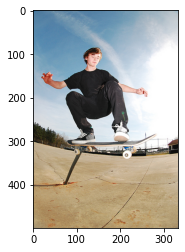

In [ ]:
#ploting sample
next_pix = imgIdss
img = coco_annotation.loadImgs(next_pix[0])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

A large boat and a small yellow boat docked in the water.
A tilting boat is seen near a dock, with a larger ship in the background.
A large boat sitting next to a dock near a small boat.
Large ship sitting out of here with a small near it. 
a crooked boat sits next to a dock 


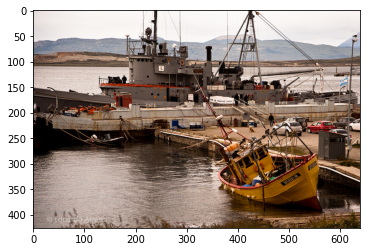

In [ ]:
next_pix = imgIdss
img = coco_annotation.loadImgs(next_pix[4000])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

A soccer goalie and a player face off in a game.
A soccer goalie preparing to stop a ball.
this is a soccer goalie standing in front of the net
Two young men practice soccer on a field.
A man standing in a soccer goals preparing to stop a ball.


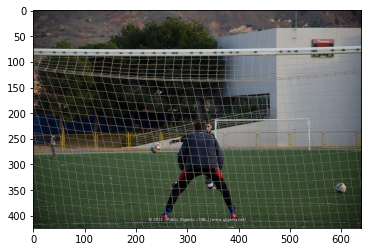

In [ ]:
next_pix = imgIdss
img = coco_annotation.loadImgs(next_pix[8000])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

# Preprocessing data
for this purpose, we should remove all punctuation and lower case all letters and save them 

In [ ]:
# using string library, we print all possible punctuation

print(f'all possible punctuations = {string.punctuation}')
punc_remove = string.punctuation
# testing removing punctoation and then iterating through whole data
imgid = imgIdss[0]
img_temp = coco_annotation.loadImgs(imgid)
img_temp = img_temp[0]
annot_id = coco_caps.getAnnIds(imgIds=img_temp['id'])
print(f"ids of captions related to selected image = {annot_id}")
annots = coco_caps.loadAnns(annot_id)
annots_temp = annots[2]
print(f"chosen annotation = {annots_temp['caption']}")
cap = annots_temp['caption']
remove_translate = str.maketrans('', '', string.punctuation)
cap = cap.translate(remove_translate)
print(f'removed punctuation = {cap}')
# splitting
cap_split = cap.split()
cap_lower = [sub_cap.lower() for sub_cap in cap]
cap_lower = '<start> ' + "".join(cap_lower) + ' <end>'
print(f'processed caption = {cap_lower}')

all possible punctuations = !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
ids of captions related to selected image = [330013, 333325, 335341, 335530, 336403]
chosen annotation = The boy is testing his balance at the skateboard park.
removed punctuation = The boy is testing his balance at the skateboard park
processed caption = <start> the boy is testing his balance at the skateboard park <end>


now iterating through all of them and saving them based of their url, so we can easily download images with coco function in next parts

In [ ]:
dataset_url = dict()
remove_translate = str.maketrans('', '', string.punctuation)
for imgid in tqdm(imgIdss):
    img_temp = coco_annotation.loadImgs(imgid)[0]
    ann_Ids = coco_caps.getAnnIds(imgIds=img_temp['id']);
    anns = coco_caps.loadAnns(ann_Ids)
    imgcaptions = []
    for annot_chosen in anns:
        cap = annot_chosen['caption']
        cap = cap.translate(remove_translate)
        
        cap = cap.replace("-"," ") # therotically, we should have removed - when using string.punctuation but since i see they also add
        # this part even after using translate method, i added it just in case
        
        # Split string into word list and Convert each word into lower case
        cap_split = cap.split()
        cap_lower = [sub_cap.lower() for sub_cap in cap]
        cap_lower = '<start> ' + "".join(cap_lower) + ' <end>'
        imgcaptions.append(cap_lower)
        
    dataset_url[img_temp['coco_url']] = imgcaptions
    
    
print("number of image samples in Dataset: ",len(dataset_url))

In [ ]:
# saving process

with open('/content/gdrive/MyDrive/deep_learning/HW04/saved_dictionary.pkl', 'wb') as f:
    pickle.dump(dataset_url, f)

In [ ]:
        
with open('/content/gdrive/MyDrive/deep_learning/HW04/saved_dictionary.pkl', 'rb') as f:
    vocab_dict = pickle.load(f)

In [ ]:
all_vocab = list(chain.from_iterable(vocab_dict.values())) # turn list of lists to one big list
print(f'first 20 words of created list = {all_vocab[0:20]}') # as we can see they are not seperated anymore(they are one big list instead of list of lists)
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(all_vocab)

first 20 words of created list = ['<start> a young man performing a jump on his skateboard <end>', '<start> a boy jumps on a skateboard at a skate park <end>', '<start> the boy is testing his balance at the skateboard park <end>', '<start> a skateboarder performing a trick on his skateboard <end>', '<start> a young man in the air doing tricks on a skateboard <end>', '<start> a man is riding a skateboard on a concrete surface <end>', '<start> a man riding a skateboard inside of ramp <end>', '<start> a man riding a skateboard with ramps behind him <end>', '<start> a man skateboards in a half pipe while his friends watch <end>', '<start> a man riding a skateboard in a concrete pool style skate park and doing a trick on the side of a platform <end>', '<start> the skateboarder is putting on a show using the picnic table as his stage <end>', '<start> a skateboarder pulling tricks on top of a picnic table <end>', '<start> a man riding on a skateboard on top of a table <end>', '<start> a skate

In [ ]:
# printing vocab size
vocab_size = len(tokenizer.word_index)+1
print(f"number of unique word in our created vocabulary = {vocab_size}")

number of unique word in our created vocabulary = 6429


In [ ]:
# printing ID of some words and testing id indicate to what wors
print("deep ID in our vocabulary = : ", tokenizer.word_index['deep'])
print("learning ID in our vocabulary: ", tokenizer.word_index['learning'])
print("course ID in our vocabulary = : ", tokenizer.word_index['course'])

print(" ID 10 in our vocabulary maps to word = : ", tokenizer.index_word[10])
print(" ID 100 in our vocabulary maps to word = : ", tokenizer.index_word[100])
print(" ID 117 in our vocabulary maps to word = : ", tokenizer.index_word[117])


deep ID in our vocabulary = :  1326
learning ID in our vocabulary:  727
course ID in our vocabulary = :  390
 ID 10 in our vocabulary maps to word = :  of
 ID 100 in our vocabulary maps to word = :  couple
 ID 117 in our vocabulary maps to word = :  flying


In [ ]:
model_cnn = ResNet50(include_top=False, pooling='avg',input_shape = (224,224,3),weights="imagenet")
print(model_cnn.summary())

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
def preprocess_img(image,shape):
  """
  preprocessing image, making sure it has tree dimension, adding a dimenssion to make it like (1,x,x,3) so we can feed it to network 
  and normalize it between 0 and 1
  inputs:
    image: input image
    shape: shape we want to resize image to
  outputs:
    out_img: processed image

  """
  if image.ndim != 3:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
  image = cv2.resize(image,(shape,shape))
  image = np.expand_dims(image, axis=0)
  out_img = image/255.0
  return out_img



In [ ]:
# now we create a dictionary for keys features
img_dic = {}
for id in tqdm(vocab_dict.keys()):
  image_loaded = io.imread(id)
  image_loaded = preprocess_img(image_loaded,224)
  img_dic[id] = model_cnn(image_loaded)


  0%|          | 0/9446 [00:00<?, ?it/s]

In [ ]:

with open('/content/gdrive/MyDrive/deep_learning/HW04/saved_dictionary_img.pkl', 'wb') as f:
    pickle.dump(img_dic, f)

In [ ]:
        
with open('/content/gdrive/MyDrive/deep_learning/HW04/saved_dictionary_img.pkl', 'rb') as f:
    image_dict = pickle.load(f)

In [ ]:
counter = 0
for key in image_dict.keys():
  counter = counter + 1
  if counter == 4000:
    print(key)
    counter = counter + 1



http://images.cocodataset.org/train2017/000000231644.jpg


In [ ]:
np.shape(image_dict['http://images.cocodataset.org/train2017/000000417793.jpg'])

TensorShape([1, 2048])

now that we extracted features, we should find padding(max len) and create our data loader

In [ ]:
all_desc = []
for key in vocab_dict.keys():
  [all_desc.append(d) for d in vocab_dict[key]]


max_len =  max(len(d.split()) for d in all_desc)
print(f"max len = {max_len}")

max len = 51


now dataloader

In [ ]:
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    
    # walk through each description for the image
    for desc in desc_list:
        
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            
            # store
            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output
            
    return np.array(X1), np.array(X2), np.array(y)

In [ ]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():

            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
            


In [ ]:
print('Dataset: ', len(vocab_dict))
print('Descriptions: train=', len(vocab_dict))
print('Number Photos: train=', len(image_dict))
print('Vocabulary Size:', vocab_size)
print('Max Description Length: ', max_len)

data_generator = data_generator(vocab_dict, image_dict, tokenizer, max_len)

Dataset:  9446
Descriptions: train= 9446
Number Photos: train= 9446
Vocabulary Size: 6429
Max Description Length:  51


In [ ]:
for train,output in data_generator:
  train_first = train
  output_first = output
  break

printing a sample input (for same image different words)

In [ ]:
print(train_first)

[array([[0.      , 0.      , 0.      , ..., 2.384183, 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 2.384183, 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 2.384183, 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 2.384183, 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 2.384183, 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 2.384183, 0.      , 0.      ]],
      dtype=float32), array([[ 0,  0,  0, ...,  0,  0,  4],
       [ 0,  0,  0, ...,  0,  4,  2],
       [ 0,  0,  0, ...,  4,  2, 23],
       ...,
       [ 0,  0,  0, ..., 41, 89,  5],
       [ 0,  0,  0, ..., 89,  5,  2],
       [ 0,  0,  0, ...,  5,  2, 11]], dtype=int32)]


we try different kinds of model, first the model that question wanted from us:

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import add,Concatenate 

from tensorflow.keras.models import Model, load_model
def define_model_input_feature(total_words, max_length):

    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    fe3 = Dense(256, activation='relu')(fe1)
    caption_states = [fe2,fe3]
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    decoder_lstm = LSTM(256)
    decoder_outputs= decoder_lstm(se1,initial_state=caption_states)
    decoder2 = Dense(256, activation='relu')(decoder_outputs)
    outputs = Dense(total_words, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [ ]:
model = define_model_input_feature(vocab_size, max_len)
steps = len(vocab_dict)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 51, 256)      1645824     ['input_2[0][0]']                
                                                                                              

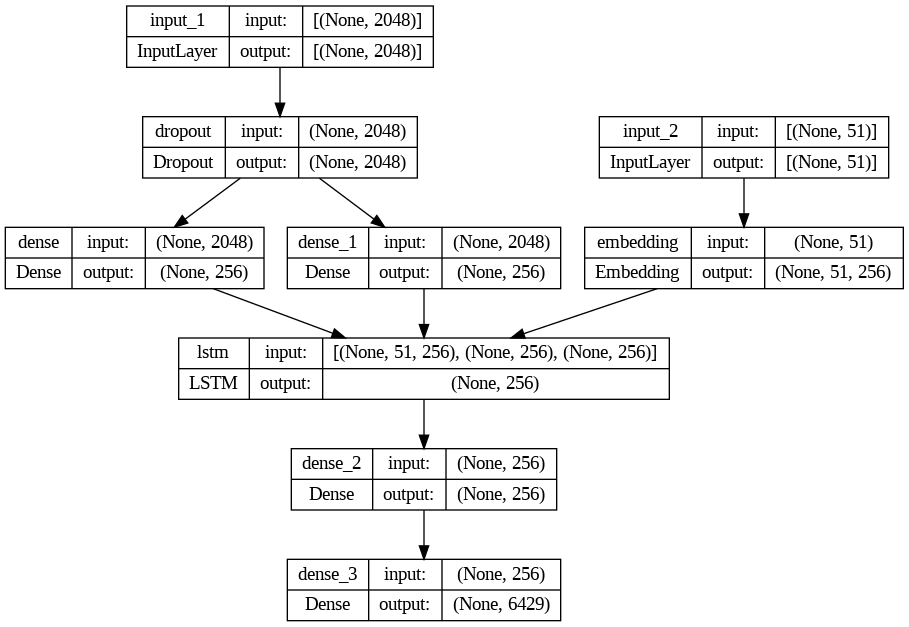

In [ ]:
from IPython.display import Image
Image('/content/model.png')

In [ ]:
model.fit(data_generator, epochs=3, steps_per_epoch= steps, verbose=1)
model.save("/content/gdrive/MyDrive/models_HW04/model_1.h5")

Epoch 1/3
9446/9446 [==============================] - 1361s 144ms/step - loss: 2.8815
Epoch 2/3
9446/9446 [==============================] - 1329s 141ms/step - loss: 2.4258
Epoch 3/3
9446/9446 [==============================] - 1332s 141ms/step - loss: 2.2747


now lets see how good this model can work!
first lets load cnn model once again and also our image preprocess 

In [ ]:
model_cnn = ResNet50(include_top=False, pooling='avg',input_shape = (224,224,3),weights="imagenet")
print(model_cnn.summary())
def preprocess_img(image,shape):
  """
  preprocessing image, making sure it has tree dimension, adding a dimenssion to make it like (1,x,x,3) so we can feed it to network 
  and normalize it between 0 and 1
  inputs:
    image: input image
    shape: shape we want to resize image to
  outputs:
    out_img: processed image

  """
  if image.ndim != 3:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
  image = cv2.resize(image,(shape,shape))
  image = np.expand_dims(image, axis=0)
  out_img = image/255.0
  return out_img
def feature_extract_img(id):
  image_loaded = io.imread(id)
  image_loaded = preprocess_img(image_loaded,224)
  out = model_cnn(image_loaded)
  return out



94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def image_captioner(model, tokenizer, img_feature, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_len)
        pred = model.predict([img_feature,sequence], verbose=0)
        pred  = np.random.choice(np.arange(0, len(pred.squeeze())), p=pred.squeeze())
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            break
    return in_text

start a teenager skateboarding on the edge of a slope end


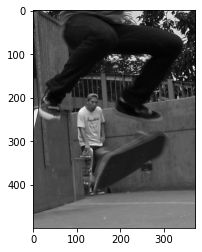

In [ ]:
next_pix = imgIdss
img = coco_annotation.loadImgs(next_pix[200])[0]
id_temp = img['coco_url']
out = feature_extract_img(id_temp)
in_text = image_captioner(model,tokenizer,out,max_len)
I = io.imread(id_temp)
plt.imshow(I)
print(in_text)
plt.show()

start some people one hand the bridal of someone riding a skateboard in the park end


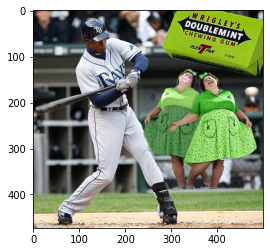

In [ ]:
next_pix = imgIdss
img = coco_annotation.loadImgs(next_pix[6000])[0]
id_temp = img['coco_url']
out = feature_extract_img(id_temp)
in_text = image_captioner(model,tokenizer,out,max_len)
I = io.imread(id_temp)
plt.imshow(I)
print(in_text)
plt.show()

start a young child who is skating down a small ramp end


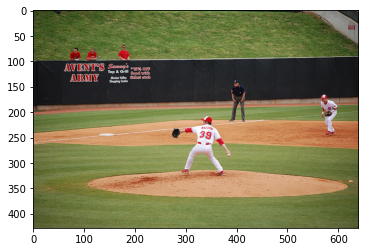

In [ ]:
next_pix = imgIdss
img = coco_annotation.loadImgs(next_pix[9000])[0]
id_temp = img['coco_url']
out = feature_extract_img(id_temp)
in_text = image_captioner(model,tokenizer,out,max_len)
I = io.imread(id_temp)
plt.imshow(I)
print(in_text)
plt.show()

as we can see,results are not good! lets try to modify model and see if helpd out result

for second method, we use model described on HW report, which means we stack features with embedded output and give it as input to lstm

In [62]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import add,Concatenate,Reshape

from tensorflow.keras.models import Model, load_model
def define_model_input_feature_stack(total_words, max_length):

    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)

    n1 = np.shape(se2)
    n2,n3 = n1[1],n1[2]
    re_layer = Reshape((n2*n3,),input_shape=(n2,n3))
    resh = re_layer(se2)
    conc_layer = Concatenate()([fe2,resh])
    re_layer2 = Reshape((int(n2)+1,n3) , input_shape=(np.shape(conc_layer)))
    input_lstm = re_layer2(conc_layer)
    decoder_lstm = LSTM(256)
    decoder_outputs= decoder_lstm(input_lstm)
    decoder2 = Dense(256, activation='relu')(decoder_outputs)
    outputs = Dense(total_words, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [64]:
model = define_model_input_feature_stack(vocab_size, max_len)
steps = len(vocab_dict)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 51, 256)      2163968     ['input_7[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 2048)         0           ['input_6[0][0]']                
                                                                                            

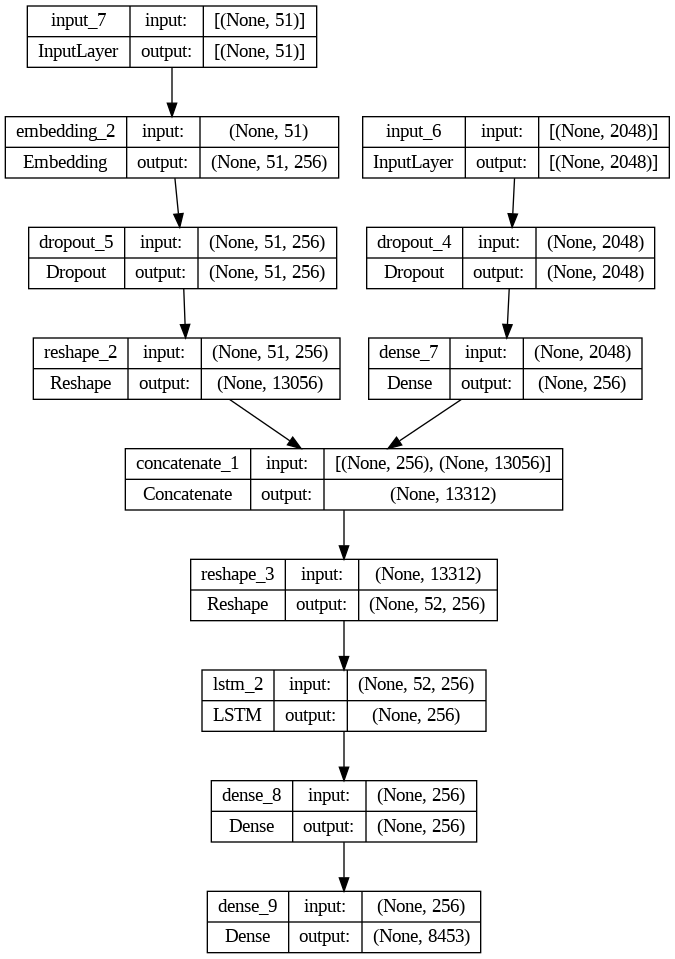

In [65]:
from IPython.display import Image
Image('/content/model.png')

In [ ]:
model.fit(data_generator, epochs=3, steps_per_epoch= steps, verbose=1)
model.save("/content/gdrive/MyDrive/models_HW04/model_2.h5")

Epoch 1/3
9446/9446 [==============================] - 1390s 147ms/step - loss: 2.9073
Epoch 2/3
9446/9446 [==============================] - 1379s 146ms/step - loss: 2.4265
Epoch 3/3
9446/9446 [==============================] - 1367s 145ms/step - loss: 2.2927


start there is a game at this skateboarding jump end


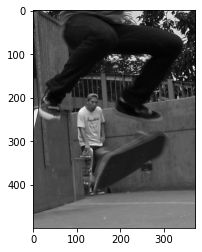

In [ ]:
next_pix = imgIdss
img = coco_annotation.loadImgs(next_pix[200])[0]
id_temp = img['coco_url']
out = feature_extract_img(id_temp)
in_text = image_captioner(model,tokenizer,out,max_len)
I = io.imread(id_temp)
plt.imshow(I)
print(in_text)
plt.show()

problem for both models is their superbiased for skateboard playing and its because data we trained have so many skateboard images at first,lets try to change image order and this time we train with xception network

## training model again using shuffled data

In [ ]:
cat_ids = coco_annotation.getCatIds()
print(f"Number of Unique Categories: {len(cat_ids)}")
print("Category IDs:")
print(cat_ids)
cats = coco_annotation.loadCats(cat_ids)
cat_names = [cat["name"] for cat in cats]
print("Categories Names:")
print(cat_names)

# Category ID -> Category Name.
query_id = cat_ids[0]
query_annotation = coco_annotation.loadCats([query_id])[0]
query_name = query_annotation["name"]
query_supercategory = query_annotation["supercategory"]
print(f"Category ID: {query_id}, Category Name: {query_name}, Supercategory: {query_supercategory}")
query_name = cat_names[0]
query_id = coco_annotation.getCatIds(catNms=[query_name])[0]
print("Category Name -> ID:")
print(f"Category Name: {query_name}, Category ID: {query_id}")

# Get the ID of all the images containing the object of the category.
img_ids = coco_annotation.getImgIds(catIds=[query_id])
print(f"Number of Images Containing {query_name}: {len(img_ids)}")

Number of Unique Categories: 80
Category IDs:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]
Categories Names:
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted

In [ ]:
# get all ids
imgIdss = coco_annotation.getImgIds()
print("Number of images containing all the  classes:", len(imgIdss))


Number of images containing all the  classes: 118287


In [ ]:
catIds = coco_annotation.getCatIds(catNms=['person', 'skateboard'])
catIds2 = coco_annotation.getCatIds(catNms=['person', 'dog'])
catIds3 = coco_annotation.getCatIds(catNms=['person', 'sports ball'])


# Get all images containing the above Category IDs
imgIdss = coco_annotation.getImgIds(catIds=catIds) + coco_annotation.getImgIds(catIds=catIds2) +coco_annotation.getImgIds(catIds=catIds3)
print("Number of images containing all the  classes:", len(imgIdss))

Number of images containing all the  classes: 9563


shuffling ids!

In [ ]:
import random
random.shuffle(imgIdss)

In [ ]:
annFile = "/content/gdrive/MyDrive/deep_learning/HW04/captions_train2017.json"
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=1.41s)
creating index...
index created!


Young child in grassy field with ball and flying disc.
a young girl playing with a ball and Frisbee 
A young girl is holding a ball and a racquet in a field
A young girl standing on top of a lush green field.
A little girl that is standing in the grass.


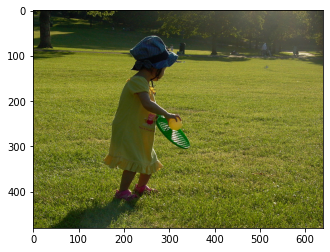

In [ ]:
#ploting sample
next_pix = imgIdss
img = coco_annotation.loadImgs(next_pix[0])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

In [ ]:
# using string library, we print all possible punctuation

print(f'all possible punctuations = {string.punctuation}')
punc_remove = string.punctuation
# testing removing punctoation and then iterating through whole data
imgid = imgIdss[0]
img_temp = coco_annotation.loadImgs(imgid)
img_temp = img_temp[0]
annot_id = coco_caps.getAnnIds(imgIds=img_temp['id'])
print(f"ids of captions related to selected image = {annot_id}")
annots = coco_caps.loadAnns(annot_id)
annots_temp = annots[2]
print(f"chosen annotation = {annots_temp['caption']}")
cap = annots_temp['caption']
remove_translate = str.maketrans('', '', string.punctuation)
cap = cap.translate(remove_translate)
print(f'removed punctuation = {cap}')
# splitting
cap_split = cap.split()
cap_lower = [sub_cap.lower() for sub_cap in cap]
cap_lower = '<start> ' + "".join(cap_lower) + ' <end>'
print(f'processed caption = {cap_lower}')

all possible punctuations = !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
ids of captions related to selected image = [777488, 778529, 779669, 780554, 781169]
chosen annotation = A young girl is holding a ball and a racquet in a field
removed punctuation = A young girl is holding a ball and a racquet in a field
processed caption = <start> a young girl is holding a ball and a racquet in a field <end>


we can remove stop words but in image captioning, stop words are important so we decide to keep them.

In [ ]:
dataset_url = dict()
remove_translate = str.maketrans('', '', string.punctuation)
for imgid in tqdm(imgIdss):
    img_temp = coco_annotation.loadImgs(imgid)[0]
    ann_Ids = coco_caps.getAnnIds(imgIds=img_temp['id']);
    anns = coco_caps.loadAnns(ann_Ids)
    imgcaptions = []
    for annot_chosen in anns:
        cap = annot_chosen['caption']
        cap = cap.translate(remove_translate)
        
        cap = cap.replace("-"," ") # therotically, we should have removed - when using string.punctuation but since i see they also add
        # this part even after using translate method, i added it just in case
        
        # Split string into word list and Convert each word into lower case
        cap_split = cap.split()
        cap_lower = [sub_cap.lower() for sub_cap in cap]
        cap_lower = '<start> ' + "".join(cap_lower) + ' <end>'
        imgcaptions.append(cap_lower)
        
    dataset_url[img_temp['coco_url']] = imgcaptions
    
    
print("number of image samples in Dataset: ",len(dataset_url))

  0%|          | 0/9563 [00:00<?, ?it/s]

number of image samples in Dataset:  9446


In [ ]:

with open('/content/gdrive/MyDrive/deep_learning/HW04/saved_dictionary.pkl', 'wb') as f:
    pickle.dump(dataset_url, f)

In [ ]:
        
with open('/content/gdrive/MyDrive/deep_learning/HW04/saved_dictionary.pkl', 'rb') as f:
    vocab_dict = pickle.load(f)

In [ ]:
all_vocab = list(chain.from_iterable(vocab_dict.values())) # turn list of lists to one big list
print(f'first 20 words of created list = {all_vocab[0:20]}') # as we can see they are not seperated anymore(they are one big list instead of list of lists)
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(all_vocab)

first 20 words of created list = ['<start> young child in grassy field with ball and flying disc <end>', '<start> a young girl playing with a ball and frisbee  <end>', '<start> a young girl is holding a ball and a racquet in a field <end>', '<start> a young girl standing on top of a lush green field <end>', '<start> a little girl that is standing in the grass <end>', '<start> a man trying to fly a kite in a field <end>', '<start> an older woman is flying her rainbow kite <end>', '<start> a woman is in a grassy area of a waterside stop flying a kite <end>', '<start> an older person is attempting to fly a kite <end>', '<start> a man flies a kite in the grass in front of a lake <end>', '<start> two people are going down a small road on skateboards <end>', '<start> two people are skateboarding down a hill together <end>', '<start> two skate boarders riding down a paved path <end>', '<start> two boys on a skateboard going down the street <end>', '<start> two people on skateboards riding dow

In [ ]:
# printing vocab size
vocab_size = len(tokenizer.word_index)+1
print(f"number of unique word in our created vocabulary = {vocab_size}")

number of unique word in our created vocabulary = 6429


In [ ]:
# printing ID of some words and testing id indicate to what wors
print("deep ID in our vocabulary = : ", tokenizer.word_index['deep'])
print("learning ID in our vocabulary: ", tokenizer.word_index['learning'])
print("course ID in our vocabulary = : ", tokenizer.word_index['course'])

print(" ID 10 in our vocabulary maps to word = : ", tokenizer.index_word[10])
print(" ID 100 in our vocabulary maps to word = : ", tokenizer.index_word[100])
print(" ID 117 in our vocabulary maps to word = : ", tokenizer.index_word[117])


deep ID in our vocabulary = :  1338
learning ID in our vocabulary:  731
course ID in our vocabulary = :  390
 ID 10 in our vocabulary maps to word = :  of
 ID 100 in our vocabulary maps to word = :  couple
 ID 117 in our vocabulary maps to word = :  flying


In [ ]:
model_cnn = Xception(include_top=False, pooling='avg')
print(model_cnn.summary())

83683744/83683744 [==============================] - 5s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
def preprocess_img(image,shape):
  """
  preprocessing image, making sure it has tree dimension, adding a dimenssion to make it like (1,x,x,3) so we can feed it to network 
  and normalize it between 0 and 1
  inputs:
    image: input image
    shape: shape we want to resize image to
  outputs:
    out_img: processed image

  """
  if image.ndim != 3:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
  image = cv2.resize(image,(shape,shape))
  image = np.expand_dims(image, axis=0)
  image = image/127.5
  out_img = image - 1.0
  return out_img
 


In [ ]:
img_dic = {}

for id in tqdm(vocab_dict.keys()):
  image_loaded = io.imread(id)
  image_loaded = preprocess_img(image_loaded,299)
  img_dic[id] = model_cnn(image_loaded)


  0%|          | 0/9446 [00:00<?, ?it/s]

In [ ]:

with open('/content/gdrive/MyDrive/deep_learning/HW04/saved_dictionary_img_xception.pkl', 'wb') as f:
    pickle.dump(img_dic, f)

In [ ]:
        
with open('/content/gdrive/MyDrive/deep_learning/HW04/saved_dictionary_img_xception.pkl', 'rb') as f:
    image_dict = pickle.load(f)

In [ ]:
all_desc = []
for key in vocab_dict.keys():
  [all_desc.append(d) for d in vocab_dict[key]]


max_len =  max(len(d.split()) for d in all_desc)
print(f"max len = {max_len}")

max len = 51


In [ ]:
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    
    # walk through each description for the image
    for desc in desc_list:
        
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            
            # store
            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output
            
    return np.array(X1), np.array(X2), np.array(y)

In [ ]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():

            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
            


In [ ]:
print('Dataset: ', len(vocab_dict))
print('Descriptions: train=', len(vocab_dict))
print('Number Photos: train=', len(image_dict))
print('Vocabulary Size:', vocab_size)
print('Max Description Length: ', max_len)

data_generator = data_generator(vocab_dict, image_dict, tokenizer, max_len)

Dataset:  9446
Descriptions: train= 9446
Number Photos: train= 9446
Vocabulary Size: 6429
Max Description Length:  51


in this part, we just train model to our proposed model (cnn features as input for LSTM hidden states ), in next part we show that our proposed method works better than feeding image features as lstm input.

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import add,Concatenate 

from tensorflow.keras.models import Model, load_model
def define_model_input_feature(total_words, max_length):

    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    fe3 = Dense(256, activation='relu')(fe1)
    caption_states = [fe2,fe3]
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    decoder_lstm = LSTM(256)
    decoder_outputs= decoder_lstm(se1,initial_state=caption_states)
    decoder2 = Dense(256, activation='relu')(decoder_outputs)
    outputs = Dense(total_words, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [ ]:
model = define_model_input_feature(vocab_size, max_len)
steps = len(vocab_dict)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 51, 256)      1645824     ['input_3[0][0]']                
                                                                                              

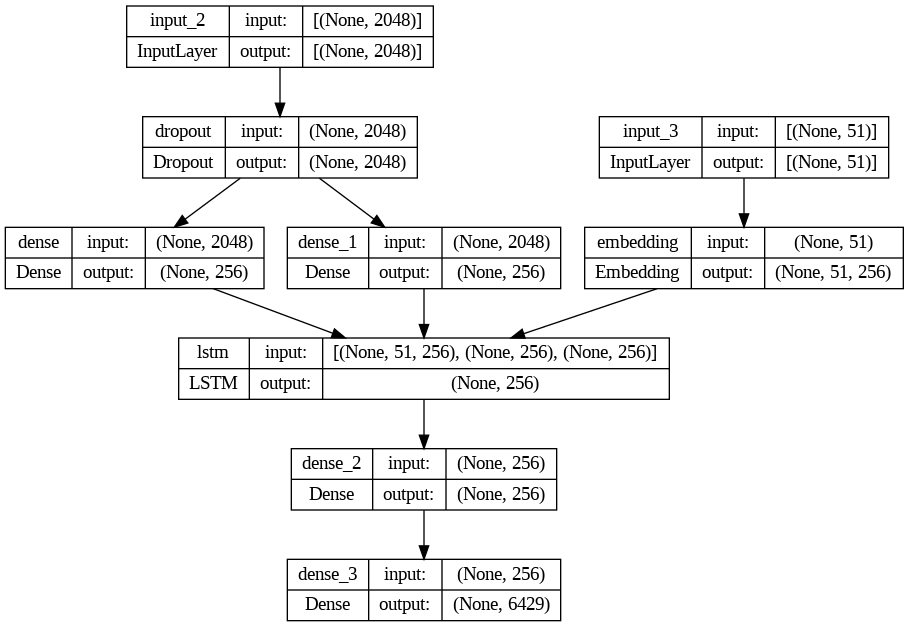

In [ ]:
from IPython.display import Image
Image('/content/model.png')

In [ ]:
model.fit(data_generator, epochs=5, steps_per_epoch= steps, verbose=1)
model.save("/content/gdrive/MyDrive/models_HW04/model_3.h5")

Epoch 1/5
9446/9446 [==============================] - 1637s 173ms/step - loss: 2.9536
Epoch 2/5
9446/9446 [==============================] - 1574s 167ms/step - loss: 2.3579
Epoch 3/5
9446/9446 [==============================] - 1536s 163ms/step - loss: 2.1910
Epoch 4/5
9446/9446 [==============================] - 1495s 158ms/step - loss: 2.0887
Epoch 5/5
9344/9446 [============================>.] - ETA: 16s - loss: 2.0132

In [ ]:
model.save("/content/gdrive/MyDrive/models_HW04/model_3.h5")

In [ ]:
model_cnn = Xception(include_top=False, pooling='avg')
print(model_cnn.summary())
def preprocess_img(image,shape):
  """
  preprocessing image, making sure it has tree dimension, adding a dimenssion to make it like (1,x,x,3) so we can feed it to network 
  and normalize it between 0 and 1
  inputs:
    image: input image
    shape: shape we want to resize image to
  outputs:
    out_img: processed image

  """
  if image.ndim != 3:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
  image = cv2.resize(image,(shape,shape))
  image = np.expand_dims(image, axis=0)
  image = image/127.5
  out_img = image - 1.0
  return out_img
def feature_extract_img(id):
  image_loaded = io.imread(id)
  image_loaded = preprocess_img(image_loaded,224)
  out = model_cnn(image_loaded)
  return out



Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_4[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

In [ ]:
def image_captioner_max(model, tokenizer, img_feature, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_len)
        pred = model.predict([img_feature,sequence], verbose=0)
      #  pred  = np.random.choice(np.arange(0, len(pred.squeeze())), p=pred.squeeze())
        pred = np.argmax(pred,axis = 1)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            break
    return in_text

lets test it on some train data

## testing model to create caption for images

start a baseball player is swinging at a ball end


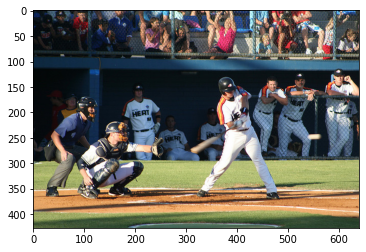

In [ ]:
next_pix = imgIdss
img = coco_annotation.loadImgs(next_pix[6888])[0]
id_temp = img['coco_url']
out = feature_extract_img(id_temp)
in_text = image_captioner_max(model,tokenizer,out,max_len)
I = io.imread(id_temp)
plt.imshow(I)
print(in_text)
plt.show()

its correct!

start a man riding a skateboard down a street end


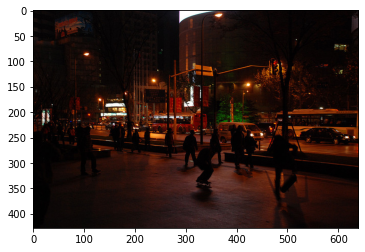

In [ ]:
next_pix = imgIdss
img = coco_annotation.loadImgs(next_pix[33])[0]
id_temp = img['coco_url']
out = feature_extract_img(id_temp)
in_text = image_captioner_max(model,tokenizer,out,max_len)
I = io.imread(id_temp)
plt.imshow(I)
print(in_text)
plt.show()

it also is a good caption

start a man in white shirt and shorts playing a game of tennis end


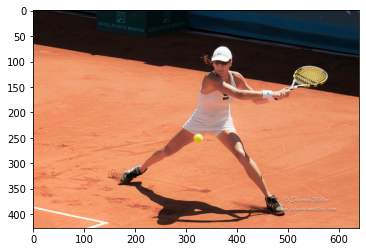

In [ ]:
next_pix = imgIdss
img = coco_annotation.loadImgs(next_pix[6666])[0]
id_temp = img['coco_url']
out = feature_extract_img(id_temp)
in_text = image_captioner_max(model,tokenizer,out,max_len)
I = io.imread(id_temp)
plt.imshow(I)
print(in_text)
plt.show()

she is a woman but yes she wore withe and playing tennis!

start a man in a white shirt playing baseball swinging a bat end


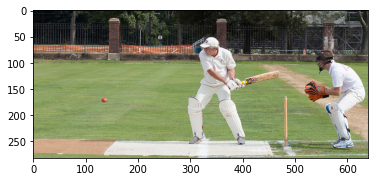

In [ ]:
next_pix = imgIdss
img = coco_annotation.loadImgs(next_pix[5500])[0]
id_temp = img['coco_url']
out = feature_extract_img(id_temp)
in_text = image_captioner_max(model,tokenizer,out,max_len)
I = io.imread(id_temp)
plt.imshow(I)
print(in_text)
plt.show()

it seems to be correct too!

start a man and a dog are playing with a frisbee in the background end


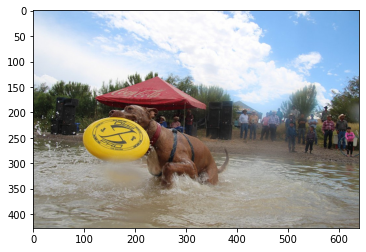

In [ ]:
next_pix = imgIdss
img = coco_annotation.loadImgs(next_pix[4300])[0]
id_temp = img['coco_url']
out = feature_extract_img(id_temp)
in_text = image_captioner_max(model,tokenizer,out,max_len)
I = io.imread(id_temp)
plt.imshow(I)
print(in_text)
plt.show()

so for train data, and the categories we trained for (sports and animals) it works really good, lets try some manual input and see results

In [ ]:
def image_captioner_generative(model, tokenizer, img_feature, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_len)
        pred = model.predict([img_feature,sequence], verbose=0)
        pred  = np.random.choice(np.arange(0, len(pred.squeeze())), p=pred.squeeze())
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            break
    return in_text

start a man smiling for a dog on the grass end


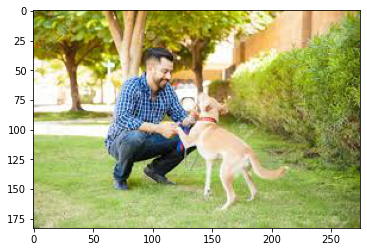

In [ ]:
out = feature_extract_img('/content/dog_man.jpg')
in_text = image_captioner_generative(model,tokenizer,out,max_len)
I = io.imread('/content/dog_man.jpg')
plt.imshow(I)
print(in_text)
plt.show()

as we can see, man really are smiling for a dog on the grass! and this image wasn't even in our training data, lets test some more

start a woman running through a field with a dog end


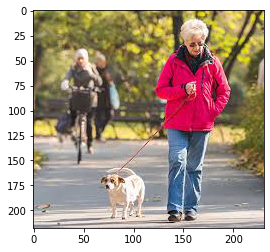

In [ ]:
out = feature_extract_img('/content/woman_dog.jpg')
in_text = image_captioner_generative(model,tokenizer,out,max_len)
I = io.imread('/content/woman_dog.jpg')
plt.imshow(I)
print(in_text)
plt.show()

its not very close but not very bad either

start a group of young men playing a game of soccer end


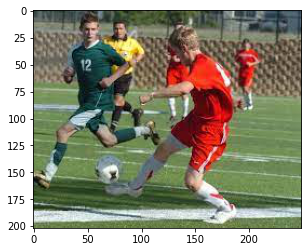

In [ ]:
out = feature_extract_img('/content/soccer.jpg')
in_text = image_captioner_generative(model,tokenizer,out,max_len)
I = io.imread('/content/soccer.jpg')
plt.imshow(I)
print(in_text)
plt.show()

it can detect that there is a group of people in the image and also the are playing soccer! 

## conclusion:
as we can see in this case model works very-well! it can detect and work.
so it was so important to shuffle data, in previous part because we didn't shuffle whole dataset, it was overfitted to our first category and couldn't work well, but by shuffling data and using xception network instead of resnet50, we achived really good result that created meaningfull and correct captions for our images


lets load and train model for some other categories to see if it works well

## Trying some other categories
as we said in previous part, we showed it works very well for our selected categories, now we want to train it on some other categories and see the result

In [8]:
cat_ids = coco_annotation.getCatIds()
print(f"Number of Unique Categories: {len(cat_ids)}")
print("Category IDs:")
print(cat_ids)
cats = coco_annotation.loadCats(cat_ids)
cat_names = [cat["name"] for cat in cats]
print("Categories Names:")
print(cat_names)

# Category ID -> Category Name.
query_id = cat_ids[0]
query_annotation = coco_annotation.loadCats([query_id])[0]
query_name = query_annotation["name"]
query_supercategory = query_annotation["supercategory"]
print(f"Category ID: {query_id}, Category Name: {query_name}, Supercategory: {query_supercategory}")
query_name = cat_names[0]
query_id = coco_annotation.getCatIds(catNms=[query_name])[0]
print("Category Name -> ID:")
print(f"Category Name: {query_name}, Category ID: {query_id}")

# Get the ID of all the images containing the object of the category.
img_ids = coco_annotation.getImgIds(catIds=[query_id])
print(f"Number of Images Containing {query_name}: {len(img_ids)}")

Number of Unique Categories: 80
Category IDs:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]
Categories Names:
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted

In [9]:
# get all ids
imgIdss = coco_annotation.getImgIds()
print("Number of images containing all the  classes:", len(imgIdss))


Number of images containing all the  classes: 118287


In [10]:
catIds = coco_annotation.getCatIds(catNms=['person','refrigerator'])
catIds2 = coco_annotation.getCatIds(catNms=['cat', 'dog'])
catIds3 = coco_annotation.getCatIds(catNms=['person', 'car'])


# Get all images containing the above Category IDs
imgIdss = coco_annotation.getImgIds(catIds=catIds) + coco_annotation.getImgIds(catIds=catIds2) +coco_annotation.getImgIds(catIds=catIds3)
print("Number of images containing all the  classes:", len(imgIdss))

Number of images containing all the  classes: 9600


In [11]:
import random
random.shuffle(imgIdss)

In [12]:
# using string library, we print all possible punctuation

print(f'all possible punctuations = {string.punctuation}')
punc_remove = string.punctuation
# testing removing punctoation and then iterating through whole data
imgid = imgIdss[0]
img_temp = coco_annotation.loadImgs(imgid)
img_temp = img_temp[0]
annot_id = coco_caps.getAnnIds(imgIds=img_temp['id'])
print(f"ids of captions related to selected image = {annot_id}")
annots = coco_caps.loadAnns(annot_id)
annots_temp = annots[2]
print(f"chosen annotation = {annots_temp['caption']}")
cap = annots_temp['caption']
remove_translate = str.maketrans('', '', string.punctuation)
cap = cap.translate(remove_translate)
print(f'removed punctuation = {cap}')
# splitting
cap_split = cap.split()
cap_lower = [sub_cap.lower() for sub_cap in cap]
cap_lower = '<start> ' + "".join(cap_lower) + ' <end>'
print(f'processed caption = {cap_lower}')

all possible punctuations = !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
ids of captions related to selected image = [617512, 618976, 619795, 623935, 625330]
chosen annotation = A very tall clock tower with a roman number clock on each of it's sides.
removed punctuation = A very tall clock tower with a roman number clock on each of its sides
processed caption = <start> a very tall clock tower with a roman number clock on each of its sides <end>


In [ ]:
dataset_url = dict()
remove_translate = str.maketrans('', '', string.punctuation)
for imgid in tqdm(imgIdss):
    img_temp = coco_annotation.loadImgs(imgid)[0]
    ann_Ids = coco_caps.getAnnIds(imgIds=img_temp['id']);
    anns = coco_caps.loadAnns(ann_Ids)
    imgcaptions = []
    for annot_chosen in anns:
        cap = annot_chosen['caption']
        cap = cap.translate(remove_translate)
        
        cap = cap.replace("-"," ") # therotically, we should have removed - when using string.punctuation but since i see they also add
        # this part even after using translate method, i added it just in case
        
        # Split string into word list and Convert each word into lower case
        cap_split = cap.split()
        cap_lower = [sub_cap.lower() for sub_cap in cap]
        cap_lower = '<start> ' + "".join(cap_lower) + ' <end>'
        imgcaptions.append(cap_lower)
        
    dataset_url[img_temp['coco_url']] = imgcaptions
    
    
print("number of image samples in Dataset: ",len(dataset_url))

  0%|          | 0/9600 [00:00<?, ?it/s]

number of image samples in Dataset:  9576


In [ ]:

with open('/content/gdrive/MyDrive/deep_learning/HW04/saved_dictionary_two.pkl', 'wb') as f:
    pickle.dump(dataset_url, f)

In [13]:
        
with open('/content/gdrive/MyDrive/deep_learning/HW04/saved_dictionary_two.pkl', 'rb') as f:
    vocab_dict = pickle.load(f)

In [14]:
all_vocab = list(chain.from_iterable(vocab_dict.values())) # turn list of lists to one big list
print(f'first 20 words of created list = {all_vocab[0:20]}') # as we can see they are not seperated anymore(they are one big list instead of list of lists)
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(all_vocab)

first 20 words of created list = ['<start> a young man with a shaved head holding a skateboard <end>', '<start> a man wearing sunglasses holding a skateboard and gesturing    <end>', '<start> a person that is holding a skateboard in the grass <end>', '<start> the man hold up his skateboard and poses for a photo <end>', '<start> a man posing for the camera holding a skateboard <end>', '<start> a man with a bike at a marina <end>', '<start> a man stands next to his bike at the marina <end>', '<start> an old man standing next to a bike and a chain fence <end>', '<start> a man holding some break standing by a bicycle <end>', '<start> a man who is standing next to his bicycle <end>', '<start> a man is looking inside a fridge with only four items in it  <end>', '<start> person in a hat looking in the fridge <end>', '<start> a man is looking into a nearly empty refrigerator <end>', '<start> a man looks inside of an empty fridge <end>', '<start> a person wearing a hat looking into an empty fri

In [15]:
# printing ID of some words and testing id indicate to what wors
print("deep ID in our vocabulary = : ", tokenizer.word_index['deep'])
print("learning ID in our vocabulary: ", tokenizer.word_index['learning'])
print("course ID in our vocabulary = : ", tokenizer.word_index['course'])

print(" ID 10 in our vocabulary maps to word = : ", tokenizer.index_word[10])
print(" ID 100 in our vocabulary maps to word = : ", tokenizer.index_word[100])
print(" ID 117 in our vocabulary maps to word = : ", tokenizer.index_word[117])


deep ID in our vocabulary = :  1970
learning ID in our vocabulary:  2537
course ID in our vocabulary = :  1150
 ID 10 in our vocabulary maps to word = :  street
 ID 100 in our vocabulary maps to word = :  yellow
 ID 117 in our vocabulary maps to word = :  ball


In [16]:
# printing vocab size
vocab_size = len(tokenizer.word_index)+1
print(f"number of unique word in our created vocabulary = {vocab_size}")

number of unique word in our created vocabulary = 8453


In [ ]:
model_cnn = Xception(include_top=False, pooling='avg')
print(model_cnn.summary())

83683744/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                   

In [17]:
def preprocess_img(image,shape):
  """
  preprocessing image, making sure it has tree dimension, adding a dimenssion to make it like (1,x,x,3) so we can feed it to network 
  and normalize it between 0 and 1
  inputs:
    image: input image
    shape: shape we want to resize image to
  outputs:
    out_img: processed image

  """
  if image.ndim != 3:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
  image = cv2.resize(image,(shape,shape))
  image = np.expand_dims(image, axis=0)
  image = image/127.5
  out_img = image - 1.0
  return out_img
 


In [ ]:
img_dic = {}

for id in tqdm(vocab_dict.keys()):
  image_loaded = io.imread(id)
  image_loaded = preprocess_img(image_loaded,299)
  img_dic[id] = model_cnn(image_loaded)


  0%|          | 0/9576 [00:00<?, ?it/s]

In [ ]:

with open('/content/gdrive/MyDrive/deep_learning/HW04/saved_dictionary_img_xception_catdog.pkl', 'wb') as f:
    pickle.dump(img_dic, f)

In [18]:
        
with open('/content/gdrive/MyDrive/deep_learning/HW04/saved_dictionary_img_xception_catdog.pkl', 'rb') as f:
    image_dict = pickle.load(f)

In [19]:
all_desc = []
for key in vocab_dict.keys():
  [all_desc.append(d) for d in vocab_dict[key]]


max_len =  max(len(d.split()) for d in all_desc)
print(f"max len = {max_len}")

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    
    # walk through each description for the image
    for desc in desc_list:
        
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            
            # store
            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output
            
    return np.array(X1), np.array(X2), np.array(y)

max len = 51


In [20]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():

            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
            


In [21]:
print('Dataset: ', len(vocab_dict))
print('Descriptions: train=', len(vocab_dict))
print('Number Photos: train=', len(image_dict))
print('Vocabulary Size:', vocab_size)
print('Max Description Length: ', max_len)

data_generator = data_generator(vocab_dict, image_dict, tokenizer, max_len)

Dataset:  9576
Descriptions: train= 9576
Number Photos: train= 9576
Vocabulary Size: 8453
Max Description Length:  51


In [22]:
for key, description_list in vocab_dict.items():
            print(description_list)
            feature = image_dict[key][0]
            break

['<start> a young man with a shaved head holding a skateboard <end>', '<start> a man wearing sunglasses holding a skateboard and gesturing    <end>', '<start> a person that is holding a skateboard in the grass <end>', '<start> the man hold up his skateboard and poses for a photo <end>', '<start> a man posing for the camera holding a skateboard <end>']


In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import add,Concatenate,Reshape

from tensorflow.keras.models import Model, load_model
def define_model_input_feature_stack(total_words, max_length):

    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)

    n1 = np.shape(se2)
    n2,n3 = n1[1],n1[2]
    re_layer = Reshape((n2*n3,),input_shape=(n2,n3))
    resh = re_layer(se2)
    conc_layer = Concatenate()([fe2,resh])
    re_layer2 = Reshape((int(n2)+1,n3) , input_shape=(np.shape(conc_layer)))
    input_lstm = re_layer2(conc_layer)
    decoder_lstm = LSTM(256)
    decoder_outputs= decoder_lstm(input_lstm)
    decoder2 = Dense(256, activation='relu')(decoder_outputs)
    outputs = Dense(total_words, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [ ]:
model = define_model_input_feature_stack(vocab_size, max_len)
steps = len(vocab_dict)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 51, 256)      2163968     ['input_5[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_4[0][0]']                
                                                                                            

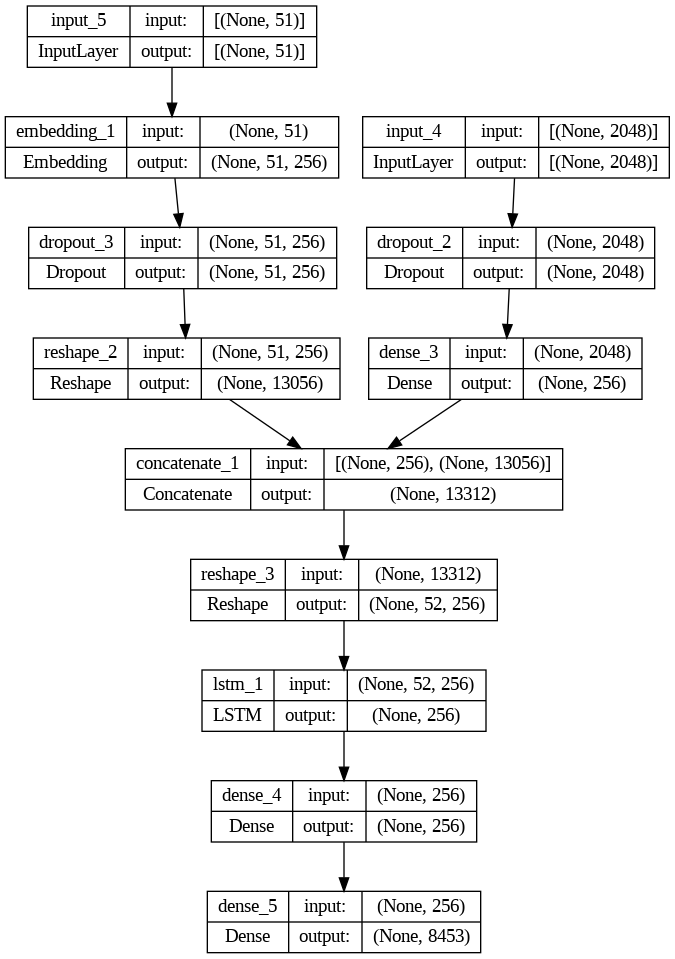

In [ ]:
from IPython.display import Image
Image('/content/model.png')

In [ ]:
model.fit(data_generator, epochs=30, steps_per_epoch= steps, verbose=1)
model.save("/content/gdrive/MyDrive/models_HW04/model_4.h5")

Epoch 1/30
9576/9576 [==============================] - 123s 13ms/step - loss: 3.7865
Epoch 2/30
9576/9576 [==============================] - 119s 12ms/step - loss: 3.1567
Epoch 3/30
9576/9576 [==============================] - 120s 13ms/step - loss: 2.9661
Epoch 4/30
9576/9576 [==============================] - 118s 12ms/step - loss: 2.8624
Epoch 5/30
9576/9576 [==============================] - 120s 13ms/step - loss: 2.7979
Epoch 6/30
9576/9576 [==============================] - 118s 12ms/step - loss: 2.7532
Epoch 7/30
9576/9576 [==============================] - 120s 13ms/step - loss: 2.7189
Epoch 8/30
9576/9576 [==============================] - 114s 12ms/step - loss: 2.6941
Epoch 9/30
9576/9576 [==============================] - 114s 12ms/step - loss: 2.6743
Epoch 10/30
9576/9576 [==============================] - 114s 12ms/step - loss: 2.6602
Epoch 11/30
9576/9576 [==============================] - 115s 12ms/step - loss: 2.6491
Epoch 12/30
9576/9576 [=============================

In [26]:
model_cnn = Xception(include_top=False, pooling='avg')
print(model_cnn.summary())
def preprocess_img(image,shape):
  """
  preprocessing image, making sure it has tree dimension, adding a dimenssion to make it like (1,x,x,3) so we can feed it to network 
  and normalize it between 0 and 1
  inputs:
    image: input image
    shape: shape we want to resize image to
  outputs:
    out_img: processed image

  """
  if image.ndim != 3:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
  image = cv2.resize(image,(shape,shape))
  image = np.expand_dims(image, axis=0)
  image = image/127.5
  out_img = image - 1.0
  return out_img
def feature_extract_img(id):
  image_loaded = io.imread(id)
  image_loaded = preprocess_img(image_loaded,224)
  out = model_cnn(image_loaded)
  return out



83683744/83683744 [==============================] - 4s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                   

In [27]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [28]:
def image_captioner_max(model, tokenizer, img_feature, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_len)
        pred = model.predict([img_feature,sequence], verbose=0)
      #  pred  = np.random.choice(np.arange(0, len(pred.squeeze())), p=pred.squeeze())
        pred = np.argmax(pred,axis = 1)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            break
    return in_text

start a man is standing in a kitchen with a sandwich end


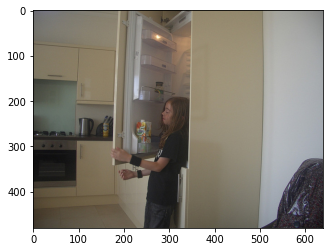

In [ ]:
next_pix = imgIdss
img = coco_annotation.loadImgs(next_pix[2])[0]
id_temp = img['coco_url']
out = feature_extract_img(id_temp)
in_text = image_captioner_max(model,tokenizer,out,max_len)
I = io.imread(id_temp)
plt.imshow(I)
print(in_text)
plt.show()

this caption is not very good, once again lets try our proposed model for captioning ( we give features as input states) to see how it performes

In [23]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import add,Concatenate 

from tensorflow.keras.models import Model, load_model
def define_model_input_feature(total_words, max_length):

    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    fe3 = Dense(256, activation='relu')(fe1)
    caption_states = [fe2,fe3]
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    decoder_lstm = LSTM(256)
    decoder_outputs= decoder_lstm(se1,initial_state=caption_states)
    decoder2 = Dense(256, activation='relu')(decoder_outputs)
    outputs = Dense(total_words, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [24]:
model = define_model_input_feature(vocab_size, max_len)
steps = len(vocab_dict)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 51, 256)      2163968     ['input_2[0][0]']                
                                                                                              

In [25]:
model.fit(data_generator, epochs=5, steps_per_epoch= steps, verbose=1)
model.save("/content/gdrive/MyDrive/models_HW04/model_5.h5")

Epoch 1/5
9576/9576 [==============================] - 1280s 133ms/step - loss: 3.6148
Epoch 2/5
9576/9576 [==============================] - 1260s 132ms/step - loss: 2.9314
Epoch 3/5
9576/9576 [==============================] - 1237s 129ms/step - loss: 2.7001
Epoch 4/5
9576/9576 [==============================] - 1232s 129ms/step - loss: 2.5592
Epoch 5/5
9576/9576 [==============================] - 1228s 128ms/step - loss: 2.4554


### Testing output for some images

start a man is sitting on a bench in a kitchen end


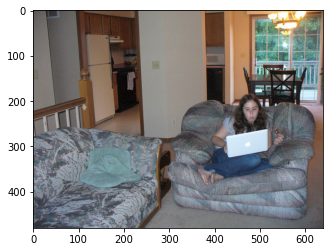

In [29]:
next_pix = imgIdss
img = coco_annotation.loadImgs(next_pix[2])[0]
id_temp = img['coco_url']
out = feature_extract_img(id_temp)
in_text = image_captioner_max(model,tokenizer,out,max_len)
I = io.imread(id_temp)
plt.imshow(I)
print(in_text)
plt.show()

as we can see output is somewhat good, because there is kitchen and there is bench but women is sitting on an bench in living room next to kitchen not in the kitchen! so our proposed model is better and we work with this model

start a group of people walking down a street end


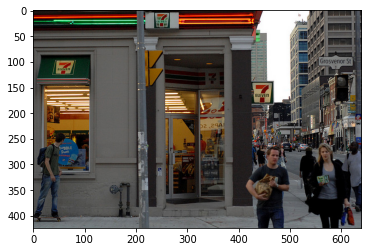

In [30]:
next_pix = imgIdss
img = coco_annotation.loadImgs(next_pix[10])[0]
id_temp = img['coco_url']
out = feature_extract_img(id_temp)
in_text = image_captioner_max(model,tokenizer,out,max_len)
I = io.imread(id_temp)
plt.imshow(I)
print(in_text)
plt.show()

output is pretty good!

start a bus and a car driving down a street end


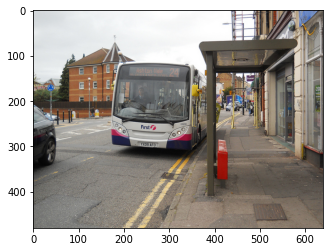

In [32]:
next_pix = imgIdss
img = coco_annotation.loadImgs(next_pix[101])[0]
id_temp = img['coco_url']
out = feature_extract_img(id_temp)
in_text = image_captioner_max(model,tokenizer,out,max_len)
I = io.imread(id_temp)
plt.imshow(I)
print(in_text)
plt.show()

it is aslo pretty good

start a group of people flying kites in a park end


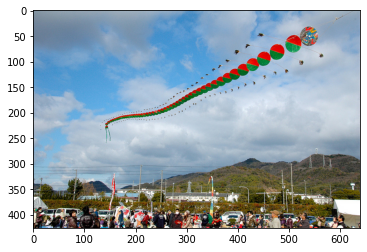

In [33]:
next_pix = imgIdss
img = coco_annotation.loadImgs(next_pix[1000])[0]
id_temp = img['coco_url']
out = feature_extract_img(id_temp)
in_text = image_captioner_max(model,tokenizer,out,max_len)
I = io.imread(id_temp)
plt.imshow(I)
print(in_text)
plt.show()

it's very good output
now lets try some images that we found on internet (but they are in same categories that we choose from coco dataset):

start a man in a kitchen with a baby in the kitchen end


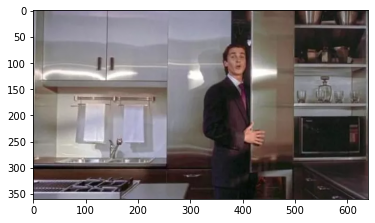

In [40]:
out = feature_extract_img('/content/kitchen.jpg')
in_text = image_captioner_max(model,tokenizer,out,max_len)
I = io.imread('/content/kitchen.jpg')
plt.imshow(I)
print(in_text)
plt.show()

there is certainly a man in the kitchen! but baby part is incorrect.

start a car with a man on the back of it end


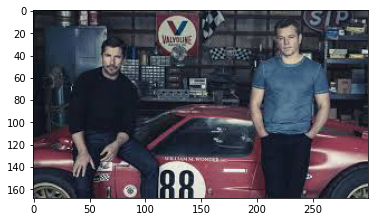

In [46]:
out = feature_extract_img('/content/car.jpg')
in_text = image_captioner_max(model,tokenizer,out,max_len)
I = io.imread('/content/car.jpg')
plt.imshow(I)
print(in_text)
plt.show()

it detected there should be car and man

start a dog and a dog are sitting on the ground end


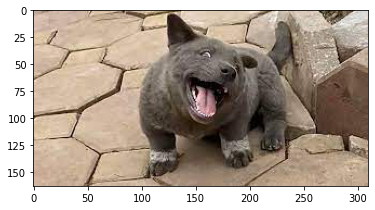

In [48]:
out = feature_extract_img('/content/dog.jpg')
in_text = image_captioner_max(model,tokenizer,out,max_len)
I = io.imread('/content/dog.jpg')
plt.imshow(I)
print(in_text)
plt.show()

it also detected there should be a dog and he is sitting on the ground, but there is a mistake in first part(repeating dog two times)

start a cat and a dog are sitting in the kitchen end


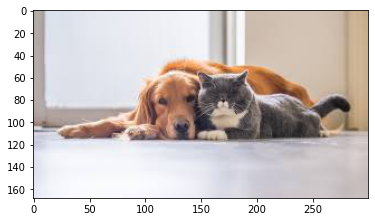

In [61]:
out = feature_extract_img('/content/dog_cat.jpg')
in_text = image_captioner_max(model,tokenizer,out,max_len)
I = io.imread('/content/dog_cat.jpg')
plt.imshow(I)
print(in_text)
plt.show()

to be honest, it could be a kitchen floor and thy are sitting here! so it's not bad caption either

# conclusion:
first we trained model on some categories without shuffling the data, so outputs were overfitted to first category (skateboard) and every caption it generated had that token, so we shuffled data and trained model again results are very good! they usually have meaningfull structire and use correct tokens to describe image, in the end we use some other categories of image to show model can learn any category (and only because of ram issues we couldn't train model on all of categories at a same time).
also we use two different models to train network, in first model we add extracted feature as input to lstm( we use dense layer anywhere necessary to change dimenssions), in second model we use extracted features with cnn as lstm initial states ( after applying dense layer on them) and we showed that second model performs much better.